In [111]:
# --- Import needed libraries ---
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [112]:
# --- Configuration ---
DATA_DIR = "dataset"
SEASONS = ["18_19", "19_20", "20_21", "21_22", "22_23", "23_24"]
LEAGUES = ["E0", "F1", "D1", "I1", "SP1"]  # EPL, Ligue 1, Bundesliga, Serie A, La Liga

In [113]:
# --- Load Data ---
def load_all_data():
    all_data = []
    for season in SEASONS:
        for league in LEAGUES:
            # Search recursively for matching files
            pattern = os.path.join(DATA_DIR, '**', f"{league}_{season}.csv")
            for path in glob(pattern, recursive=True):
                df = pd.read_csv(path)
                df['Season'] = season
                df['League'] = league
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


--- RAW DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Columns: 126 entries, Div to AvgCAHA
dtypes: float64(100), int64(16), object(10)
memory usage: 10.4+ MB
None

--- RAW DATA HEAD ---
  Div        Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  E0  10/08/2018    Man United       Leicester     2     1   H     1     0   
1  E0  11/08/2018   Bournemouth         Cardiff     2     0   H     1     0   
2  E0  11/08/2018        Fulham  Crystal Palace     0     2   A     0     1   
3  E0  11/08/2018  Huddersfield         Chelsea     0     3   A     0     2   
4  E0  11/08/2018     Newcastle       Tottenham     1     2   A     1     2   

  HTR  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0   H  ...      NaN   NaN       NaN       NaN    NaN    NaN      NaN      NaN   
1   H  ...      NaN   NaN       NaN       NaN    NaN    NaN      NaN      NaN   
2   A  ...      NaN   NaN       NaN       NaN    Na

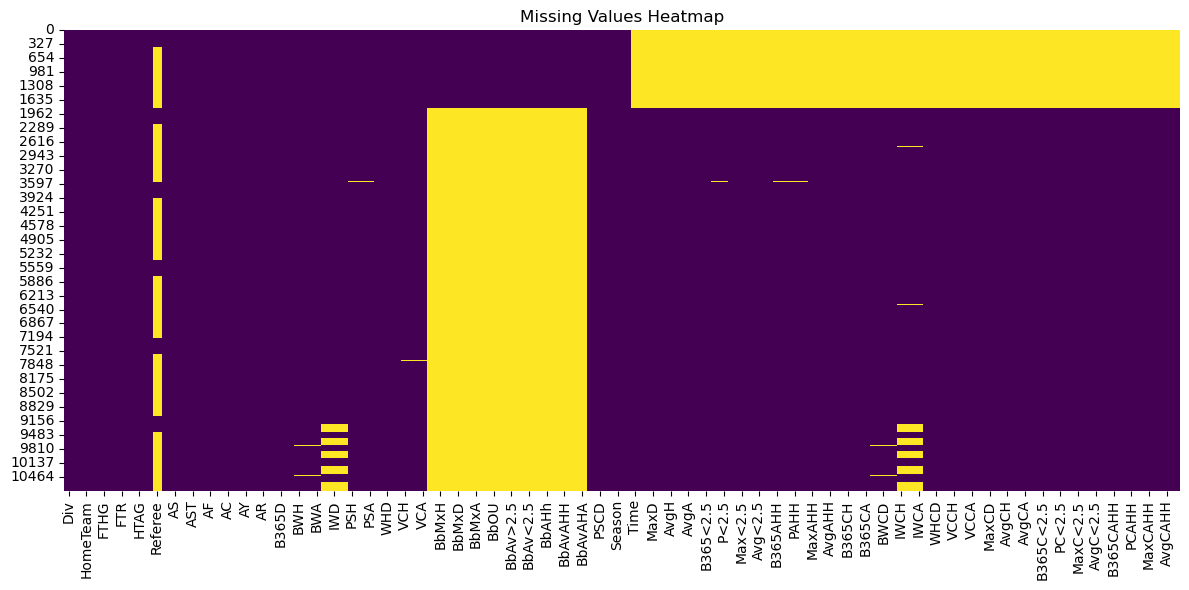

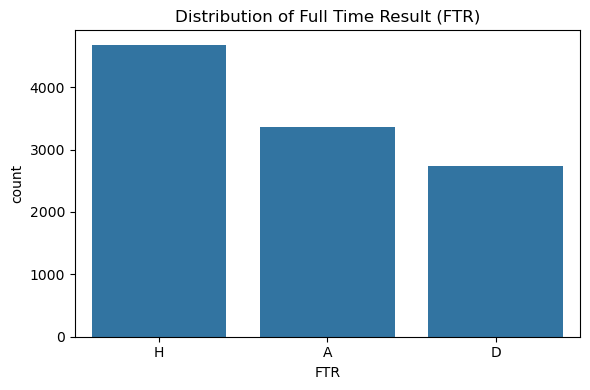

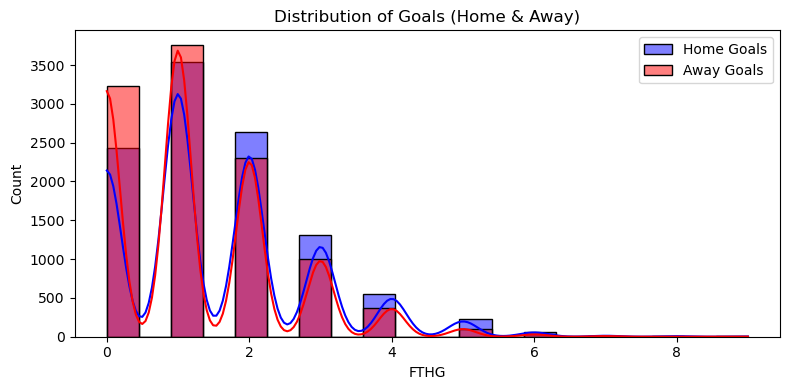

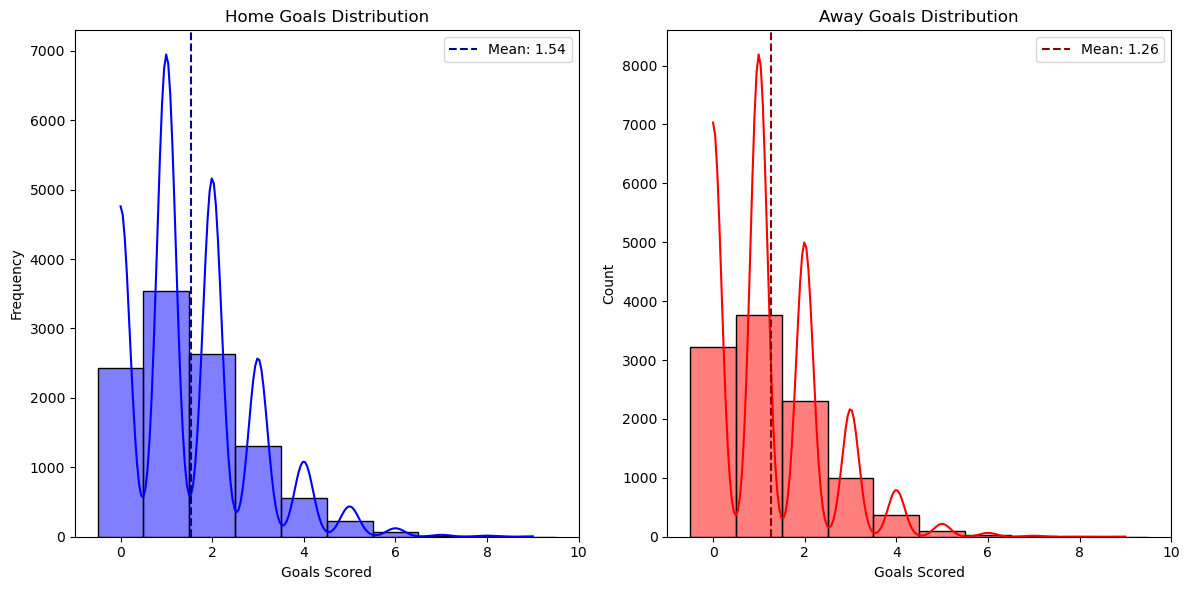


Goal Statistics:
Average home goals: 1.54
Average away goals: 1.26
Most common home goals: 1
Most common away goals: 1
Home goals std. dev: 1.30
Away goals std. dev: 1.17

Goal Statistics:
Average home goals: 1.54
Average away goals: 1.26
Most common home goals: 1
Most common away goals: 1
Home goals std. dev: 1.30
Away goals std. dev: 1.17


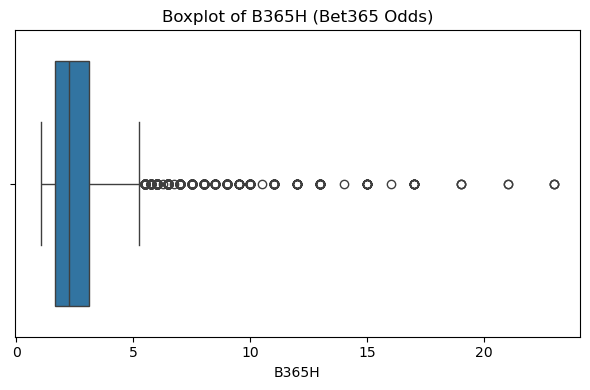

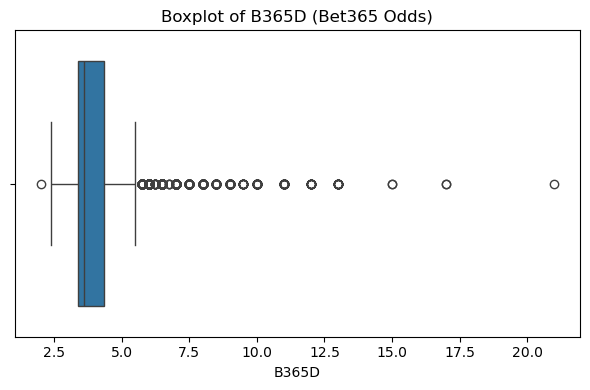

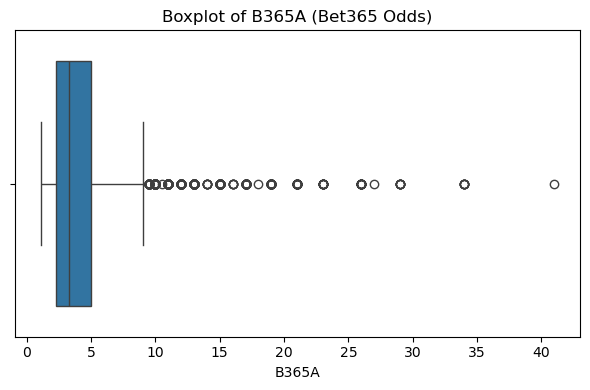

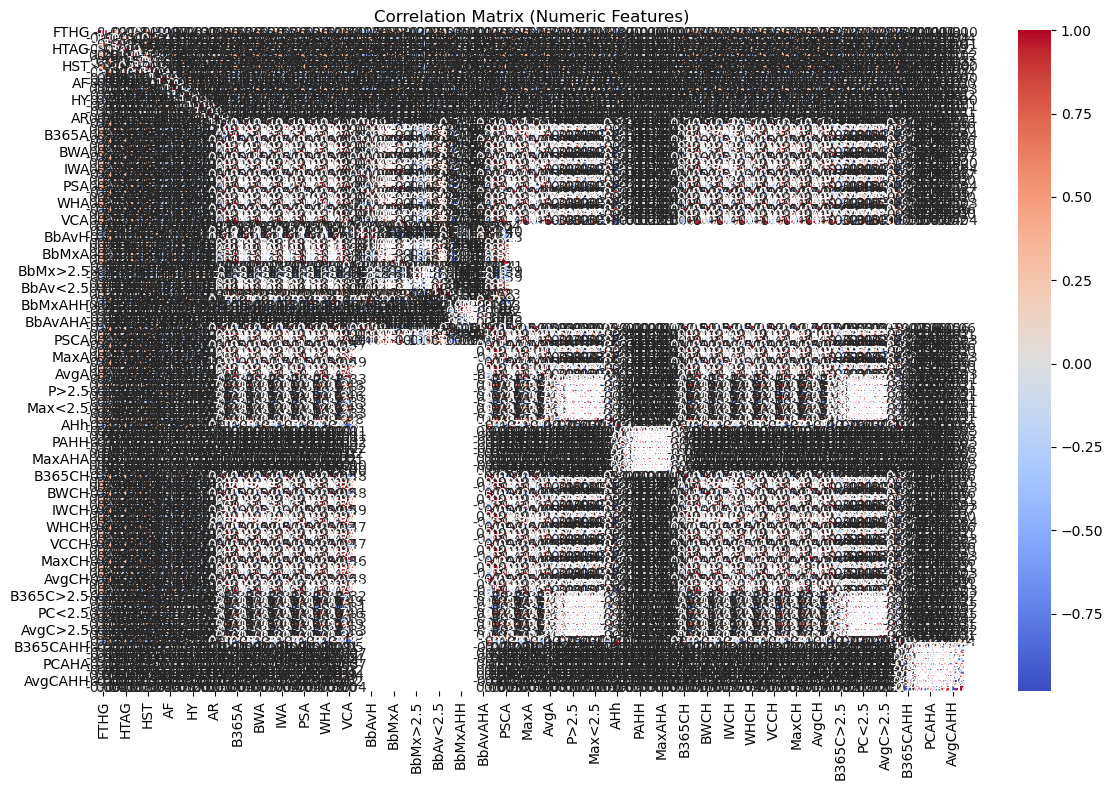

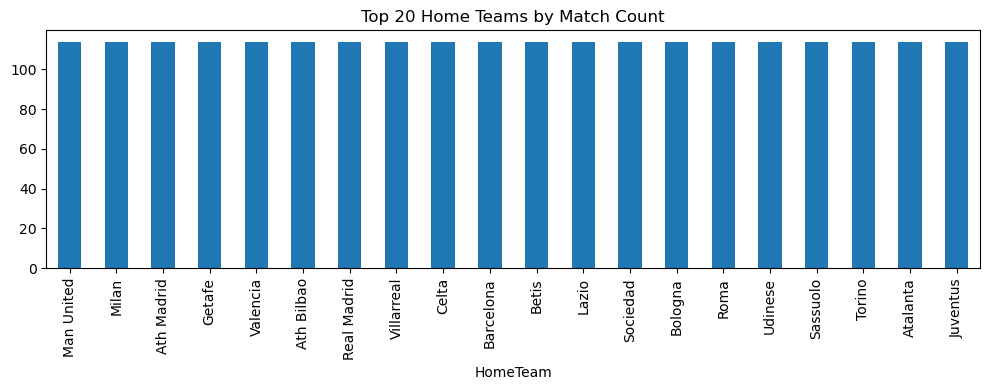

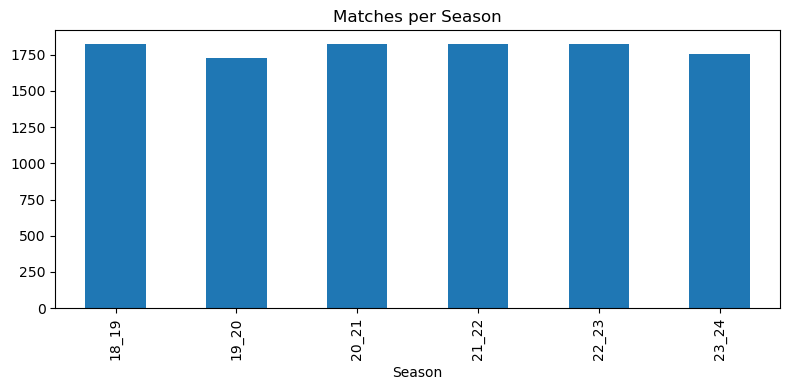

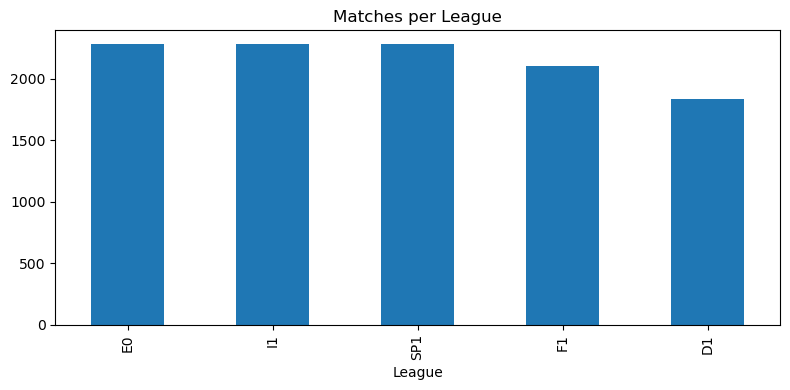

EDA outputs saved to 'outputs/' folder.


In [114]:
# --- Deep Exploratory Data Analysis (EDA) ---

def deep_eda(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    print("\n--- RAW DATA INFO ---")
    print(df.info())
    print("\n--- RAW DATA HEAD ---")
    print(df.head())
    print("\n--- RAW DATA DESCRIBE ---")
    print(df.describe(include='all'))

    # Save outputs
    os.makedirs("outputs", exist_ok=True)
    df.describe(include='all').to_csv("outputs/eda_raw_describe.csv")

    # Missing values heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig("outputs/eda_missing_heatmap.png")
    plt.show()

    # Distribution of target variable (FTR)
    if 'FTR' in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='FTR', data=df)
        plt.title('Distribution of Full Time Result (FTR)')
        plt.tight_layout()
        plt.savefig("outputs/eda_ftr_distribution.png")
        plt.show()

    # Distribution of goals
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df['FTHG'], bins=20, kde=True, color='blue', label='Home Goals')
        sns.histplot(df['FTAG'], bins=20, kde=True, color='red', label='Away Goals')
        plt.legend()
        plt.title('Distribution of Goals (Home & Away)')
        plt.tight_layout()
        plt.savefig("outputs/eda_goals_distribution.png")
        plt.show()

     # Distribution of goals alternative
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(12, 6))
    
        # Create subplots
        plt.subplot(1, 2, 1)
        sns.histplot(df['FTHG'], bins=range(0, df['FTHG'].max()+2), 
                 kde=True, color='blue', discrete=True)
        plt.title('Home Goals Distribution')
        plt.xlabel('Goals Scored')
        plt.ylabel('Frequency')
    
        # Add mean line for home goals
        mean_home = df['FTHG'].mean()
        plt.axvline(mean_home, color='darkblue', linestyle='--', 
                label=f'Mean: {mean_home:.2f}')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        sns.histplot(df['FTAG'], bins=range(0, df['FTAG'].max()+2), 
                 kde=True, color='red', discrete=True)
        plt.title('Away Goals Distribution')
        plt.xlabel('Goals Scored')
    
        # Add mean line for away goals
        mean_away = df['FTAG'].mean()
        plt.axvline(mean_away, color='darkred', linestyle='--', 
                label=f'Mean: {mean_away:.2f}')
        plt.legend()
    
        plt.tight_layout()
    
        # Save and show
        plt.savefig("outputs/eda_goals_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # Additional statistics
    print("\nGoal Statistics:")
    print(f"Average home goals: {mean_home:.2f}")
    print(f"Average away goals: {mean_away:.2f}")
    print(f"Most common home goals: {df['FTHG'].mode()[0]}")
    print(f"Most common away goals: {df['FTAG'].mode()[0]}")
    print(f"Home goals std. dev: {df['FTHG'].std():.2f}")
    print(f"Away goals std. dev: {df['FTAG'].std():.2f}")
    
    # Additional statistics
    print("\nGoal Statistics:")
    print(f"Average home goals: {mean_home:.2f}")
    print(f"Average away goals: {mean_away:.2f}")
    print(f"Most common home goals: {df['FTHG'].mode()[0]}")
    print(f"Most common away goals: {df['FTAG'].mode()[0]}")
    print(f"Home goals std. dev: {df['FTHG'].std():.2f}")
    print(f"Away goals std. dev: {df['FTAG'].std():.2f}")

    # Boxplots for odds
    for col in ['B365H', 'B365D', 'B365A']:
        if col in df.columns:
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col} (Bet365 Odds)')
            plt.tight_layout()
            plt.savefig(f"outputs/eda_boxplot_{col}.png")
            plt.show()

    # Correlation heatmap for numeric columns
    plt.figure(figsize=(12, 8))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix (Numeric Features)')
    plt.tight_layout()
    plt.savefig("outputs/eda_corr_matrix.png")
    plt.show()

    # Pairplot for selected features (if not too many rows)
    if len(df) < 2000:
        selected = ['FTHG', 'FTAG', 'B365H', 'B365D', 'B365A']
        selected = [col for col in selected if col in df.columns]
        if len(selected) > 1:
            sns.pairplot(df[selected].dropna())
            plt.savefig("outputs/eda_pairplot.png")
            plt.show()

    # Top teams by appearances
    if 'HomeTeam' in df.columns:
        plt.figure(figsize=(10, 4))
        df['HomeTeam'].value_counts().head(20).plot(kind='bar')
        plt.title('Top 20 Home Teams by Match Count')
        plt.tight_layout()
        plt.savefig("outputs/eda_top_home_teams.png")
        plt.show()

    # Season and league distribution
    if 'Season' in df.columns:
        plt.figure(figsize=(8, 4))
        df['Season'].value_counts().sort_index().plot(kind='bar')
        plt.title('Matches per Season')
        plt.tight_layout()
        plt.savefig("outputs/eda_season_distribution.png")
        plt.show()
    if 'League' in df.columns:
        plt.figure(figsize=(8, 4))
        df['League'].value_counts().plot(kind='bar')
        plt.title('Matches per League')
        plt.tight_layout()
        plt.savefig("outputs/eda_league_distribution.png")
        plt.show()

    print("EDA outputs saved to 'outputs/' folder.")

# --- Load raw data and run deep EDA ---
raw_df = load_all_data()
deep_eda(raw_df)

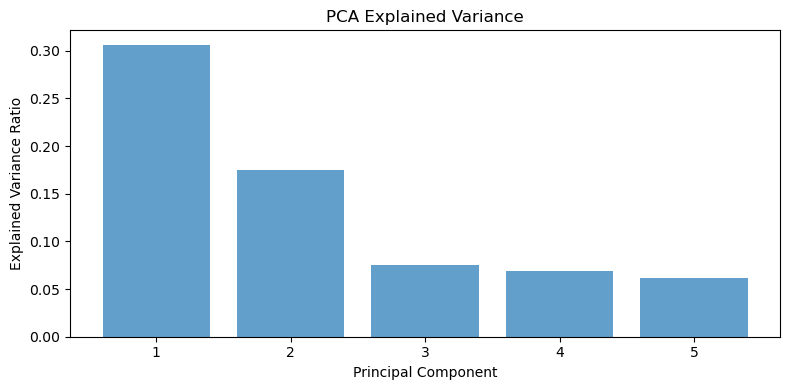

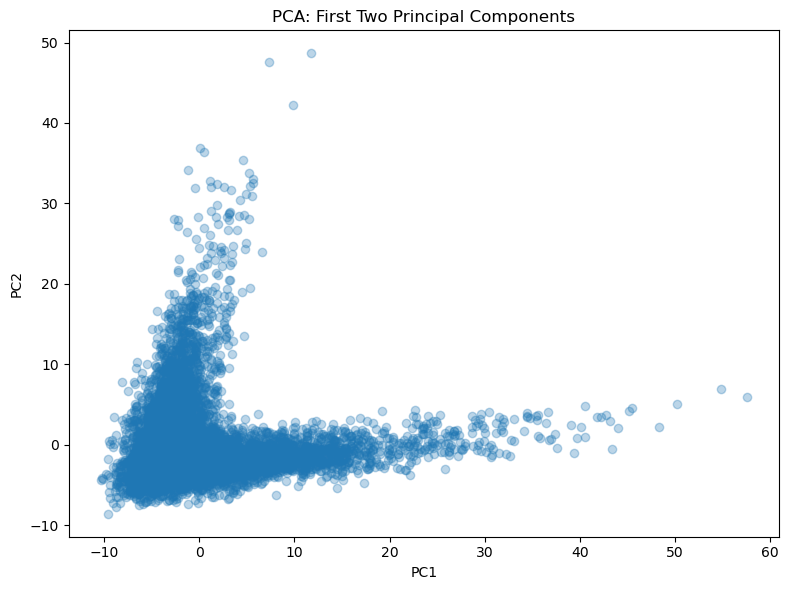


Top features for each principal component:

PC1 top features:
AvgCA    0.149533
MaxCA    0.149395
AvgA     0.149348
AvgD     0.149228
MaxA     0.149205
Name: PC1, dtype: float64

PC2 top features:
MaxH     0.195128
MaxCH    0.195124
WHH      0.194737
WHCH     0.194713
AvgCH    0.194586
Name: PC2, dtype: float64

PC3 top features:
BbAvD       0.301130
BbMxD       0.298975
BbMx<2.5    0.273392
BbMxA       0.273109
BbAv<2.5    0.272851
Name: PC3, dtype: float64

PC4 top features:
AvgAHA    0.291181
AvgAHH    0.290803
PAHA      0.290057
PAHH      0.289602
MaxAHA    0.287759
Name: PC4, dtype: float64

PC5 top features:
AvgCAHA     0.294442
AvgCAHH     0.294024
PCAHH       0.292120
PCAHA       0.291630
B365CAHA    0.287791
Name: PC5, dtype: float64


In [115]:
# --- PCA Analysis on Raw Data ---
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_analysis(df, n_components=5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    import os

    os.makedirs("outputs", exist_ok=True)

    # Select only numeric columns (exclude IDs/categorical if present)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Optionally, remove columns like 'Season', 'League' if they are encoded as numbers but are categorical
    for col in ['Season', 'League']:
        if col in numeric_cols:
            numeric_cols.remove(col)

    X = df[numeric_cols].fillna(df[numeric_cols].mean())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance plot
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.tight_layout()
    plt.savefig("outputs/pca_explained_variance.png")
    plt.show()

    # Biplot of first two principal components
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA: First Two Principal Components')
    plt.tight_layout()
    plt.savefig("outputs/pca_scatter.png")
    plt.show()

    # Feature contributions to each principal component
    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=numeric_cols)
    loadings.to_csv("outputs/pca_loadings.csv")
    print("\nTop features for each principal component:")
    for i in range(n_components):
        print(f"\nPC{i+1} top features:")
        print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(5))

# --- Run PCA on raw data after EDA ---
pca_analysis(raw_df, n_components=5)

In [116]:
# --- Feature Engineering for Team Form ---
def add_team_form_features(df, n_matches=5):
    df = df.sort_values(['Season', 'League', 'Date'])  # Ensure chronological order if 'Date' exists
    # If 'Date' is not present, sort by season, league, and match index

    # Points mapping
    result_points = {'H': 3, 'D': 1, 'A': 0}

    # Initialize form columns
    df['HomeTeam_FormPts'] = np.nan
    df['AwayTeam_FormPts'] = np.nan
    df['HomeTeam_FormGS'] = np.nan  # Goals scored
    df['AwayTeam_FormGS'] = np.nan
    df['HomeTeam_FormGC'] = np.nan  # Goals conceded
    df['AwayTeam_FormGC'] = np.nan

    # Group by team and calculate rolling stats
    for team in df['HomeTeam'].unique():
        home_matches = df[df['HomeTeam'] == team].sort_index()
        away_matches = df[df['AwayTeam'] == team].sort_index()
        all_matches = pd.concat([home_matches, away_matches]).sort_index()

        # Points in last n matches
        def get_points(row):
            if row['HomeTeam'] == team and row['FTR'] == 'H':
                return result_points['H']
            elif row['AwayTeam'] == team and row['FTR'] == 'A':
                return result_points['A']
            elif (row['HomeTeam'] == team or row['AwayTeam'] == team) and row['FTR'] == 'D':
                return result_points['D']
            else:
                return np.nan

        points = all_matches.apply(get_points, axis=1)
        rolling_points = points.shift(1).rolling(n_matches, min_periods=1).mean()
        goals_scored = np.where(all_matches['HomeTeam'] == team, all_matches['FTHG'], all_matches['FTAG'])
        goals_conceded = np.where(all_matches['HomeTeam'] == team, all_matches['FTAG'], all_matches['FTHG'])
        rolling_gs = pd.Series(goals_scored, index=all_matches.index).shift(1).rolling(n_matches, min_periods=1).mean()
        rolling_gc = pd.Series(goals_conceded, index=all_matches.index).shift(1).rolling(n_matches, min_periods=1).mean()

        # Assign back to main df
        idx = all_matches.index
        df.loc[idx, 'Team_FormPts'] = rolling_points.values
        df.loc[idx, 'Team_FormGS'] = rolling_gs.values
        df.loc[idx, 'Team_FormGC'] = rolling_gc.values

    # Assign home/away form features
    df['HomeTeam_FormPts'] = df.groupby('HomeTeam')['Team_FormPts'].transform('last')
    df['AwayTeam_FormPts'] = df.groupby('AwayTeam')['Team_FormPts'].transform('last')
    df['HomeTeam_FormGS'] = df.groupby('HomeTeam')['Team_FormGS'].transform('last')
    df['AwayTeam_FormGS'] = df.groupby('AwayTeam')['Team_FormGS'].transform('last')
    df['HomeTeam_FormGC'] = df.groupby('HomeTeam')['Team_FormGC'].transform('last')
    df['AwayTeam_FormGC'] = df.groupby('AwayTeam')['Team_FormGC'].transform('last')

    # Drop helper columns
    df = df.drop(columns=['Team_FormPts', 'Team_FormGS', 'Team_FormGC'])

    return df

In [117]:
def add_goal_superiority_feature(df, n_matches=6):
    # Ensure chronological order
    if 'Date' in df.columns:
        df = df.sort_values(['Season', 'League', 'Date'])
    else:
        df = df.sort_values(['Season', 'League']).reset_index(drop=True)

    # Prepare columns
    df['Home_GoalSup'] = np.nan
    df['Away_GoalSup'] = np.nan
    df['Match_GoalSup'] = np.nan

    # For each team, calculate rolling sums
    for team in pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K')):
        team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)].sort_index()

        # Goals scored and conceded per match
        goals_scored = np.where(team_matches['HomeTeam'] == team, team_matches['FTHG'], team_matches['FTAG'])
        goals_conceded = np.where(team_matches['HomeTeam'] == team, team_matches['FTAG'], team_matches['FTHG'])

        # Rolling sums (excluding current match)
        rolling_scored = pd.Series(goals_scored, index=team_matches.index).shift(1).rolling(n_matches, min_periods=1).sum()
        rolling_conceded = pd.Series(goals_conceded, index=team_matches.index).shift(1).rolling(n_matches, min_periods=1).sum()
        goal_sup = rolling_scored - rolling_conceded

        # Assign to main df
        for idx in team_matches.index:
            if df.at[idx, 'HomeTeam'] == team:
                df.at[idx, 'Home_GoalSup'] = goal_sup.loc[idx]
            if df.at[idx, 'AwayTeam'] == team:
                df.at[idx, 'Away_GoalSup'] = goal_sup.loc[idx]

    # Calculate match goal superiority
    df['Match_GoalSup'] = df['Home_GoalSup'] - df['Away_GoalSup']
    return df

In [118]:
# --- Feature Engineering ---
def engineer_features(df):
    df = df.dropna(subset=['FTR', 'HomeTeam', 'AwayTeam'])
    df = add_team_form_features(df)
    df = add_goal_superiority_feature(df, n_matches=6)
    # Add new features to the selected columns
    feature_cols = [
        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
        'B365H', 'B365D', 'B365A', 'Season', 'League',
        'HS', 'AS', 'HST', 'AST'
    ]
    feature_cols = [
        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
        'B365H', 'B365D', 'B365A', 'Season', 'League',
        'HS', 'AS', 'HST', 'AST',
        'HomeTeam_FormPts', 'AwayTeam_FormPts',
        'HomeTeam_FormGS', 'AwayTeam_FormGS',
        'HomeTeam_FormGC', 'AwayTeam_FormGC',
        'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup' 
    ]
    # Only keep columns that exist in the dataframe
    feature_cols = [col for col in feature_cols if col in df.columns]
    df = df[feature_cols]

    # Implied Probabilities
    df['Imp_H'] = 1 / df['B365H']
    df['Imp_D'] = 1 / df['B365D']
    df['Imp_A'] = 1 / df['B365A']
    
    # Normalize to sum to 1
    total = df[['Imp_H', 'Imp_D', 'Imp_A']].sum(axis=1)
    df['Imp_H'] /= total
    df['Imp_D'] /= total
    df['Imp_A'] /= total

    # Encode result
    df['Result'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

    # Encode teams
    le = LabelEncoder()
    df['HomeTeam'] = le.fit_transform(df['HomeTeam'])
    df['AwayTeam'] = le.fit_transform(df['AwayTeam'])

    # Encode League and Season
    df['League'] = LabelEncoder().fit_transform(df['League'])
    df['Season'] = LabelEncoder().fit_transform(df['Season'])

    return df.dropna()

In [119]:
# --- Exploratory Data Analysis ---
def perform_eda(df):
    print("\n--- EDA ---")
    print(df.describe())

    # Save EDA summary statistics to outputs folder
    os.makedirs("outputs", exist_ok=True)
    df.describe().to_csv("outputs/eda_summary.csv")

    # Histograms
    df['Result'].value_counts().plot(kind='bar', title='Match Outcome Distribution')
    plt.xlabel("Result (0=Home, 1=Draw, 2=Away)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("outputs/histogram_result.png")
    plt.show()

    # Scatter plot of odds vs. goals
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='B365H', y='FTHG', data=df)
    plt.title('Home Odds vs Full Time Home Goals')
    plt.xlabel('Home Odds')
    plt.ylabel('Home Goals')
    plt.tight_layout()
    plt.savefig("outputs/scatter_odds_vs_goals.png")
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 6))
    corr = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Imp_H', 'Imp_D', 'Imp_A', 'Result']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig("outputs/correlation_matrix.png")
    plt.show()

    # Save correlation matrix to outputs folder
    corr.to_csv("outputs/eda_correlations.csv")

In [120]:
# --- Split Train/Test ---
def split_data(df):
    test_season = df['Season'].max()
    train_df = df[df['Season'] < test_season]
    test_df = df[df['Season'] == test_season]
    X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_train = train_df['Result']
    X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_test = test_df['Result']
    return X_train, X_test, y_train, y_test

In [128]:
# --- Model Training and Evaluation ---
def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = []
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf'),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            alpha=0.0005,
            learning_rate_init=0.001,
            max_iter=500,
            early_stopping=True,
            random_state=42
        )
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='macro')
        rmse = np.sqrt(root_mean_squared_error(y_test, preds))
        print(f"\n{name}")
        print(f"Accuracy: {acc:.2f}, F1 Score: {f1:.2f}, RMSE: {rmse:.2f}")
        print(classification_report(y_test, preds))
        results.append([name, acc, f1, rmse])

    # Save results to CSV
    with open("outputs/model_evaluation.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Model", "Accuracy", "F1 Score", "RMSE"])
        writer.writerows(results)


--- EDA ---
           HomeTeam      AwayTeam          FTHG          FTAG         B365H  \
count  10683.000000  10683.000000  10683.000000  10683.000000  10683.000000   
mean      72.112515     72.181691      1.541421      1.256389      2.790275   
std       40.829859     40.865785      1.302440      1.173282      1.899545   
min        0.000000      0.000000      0.000000      0.000000      1.030000   
25%       37.000000     38.000000      1.000000      0.000000      1.670000   
50%       76.000000     76.000000      1.000000      1.000000      2.250000   
75%      108.000000    108.000000      2.000000      2.000000      3.100000   
max      139.000000    139.000000      9.000000      9.000000     23.000000   

              B365D         B365A        Season        League            HS  \
count  10683.000000  10683.000000  10683.000000  10683.000000  10683.000000   
mean       4.067610      4.368147      2.509033      2.082467     13.403632   
std        1.256354      3.503227     

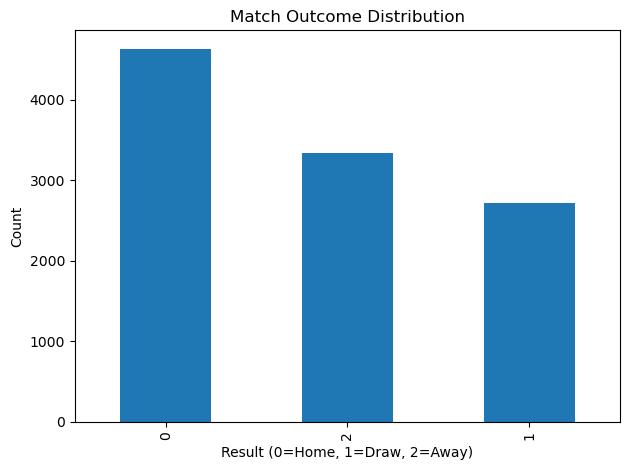

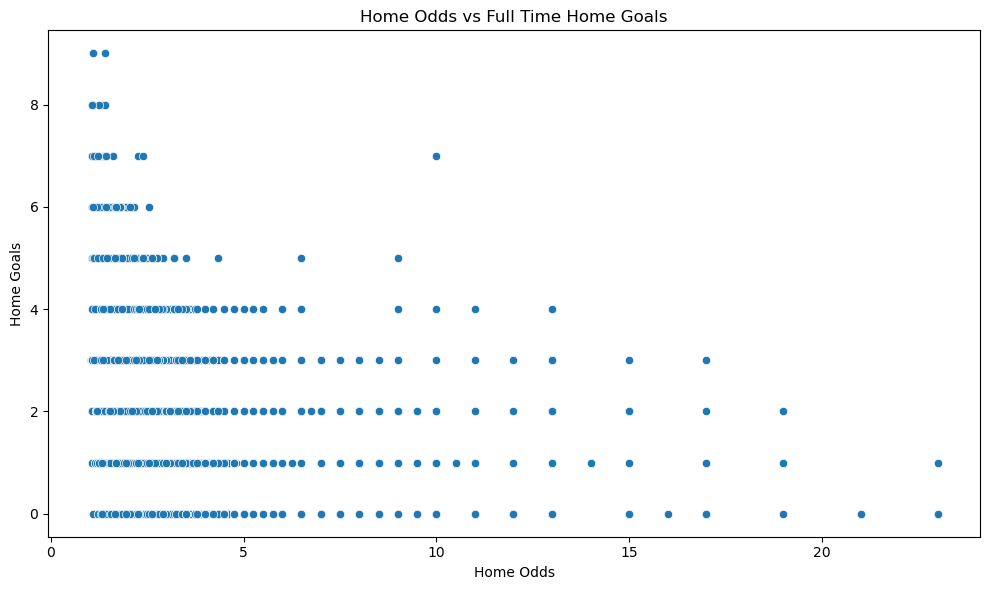

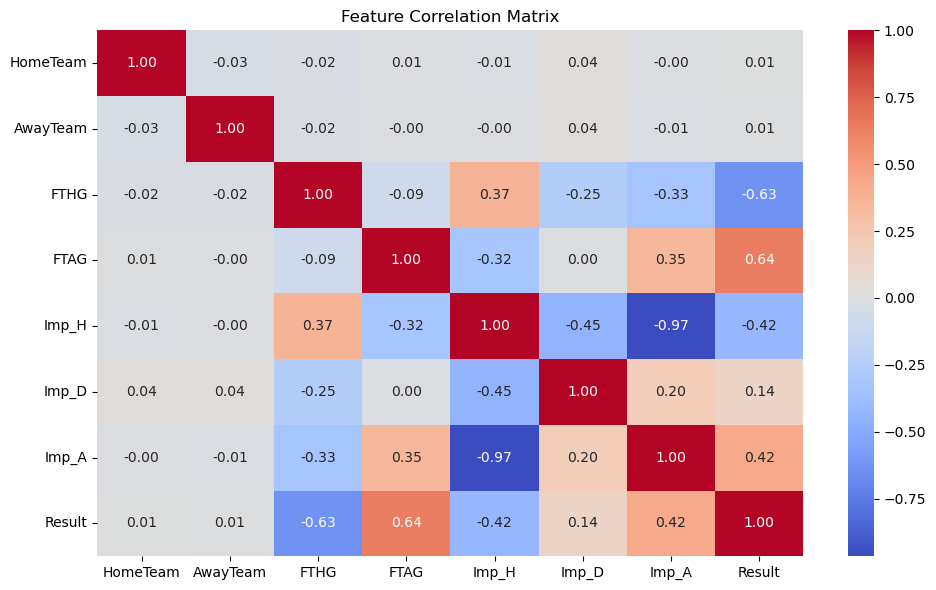

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
Accuracy: 0.60, F1 Score: 0.50, RMSE: 0.94
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       752
           1       0.39      0.08      0.13       461
           2       0.58      0.72      0.64       534

    accuracy                           0.60      1747
   macro avg       0.53      0.54      0.50      1747
weighted avg       0.55      0.60      0.54      1747


Random Forest
Accuracy: 0.58, F1 Score: 0.49, RMSE: 0.96
              precision    recall  f1-score   support

           0       0.60      0.82      0.69       752
           1       0.37      0.12      0.18       461
           2       0.58      0.63      0.61       534

    accuracy                           0.58      1747
   macro avg       0.52      0.52      0.49      1747
weighted avg       0.54      0.58      0.53      1747


SVM
Accuracy: 0.58, F1 Score: 0.44, RMSE: 0.97
              precision    recall  f1-score   support

           0 

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MLP
Accuracy: 0.59, F1 Score: 0.51, RMSE: 0.95
              precision    recall  f1-score   support

           0       0.60      0.83      0.70       752
           1       0.43      0.14      0.21       461
           2       0.60      0.63      0.62       534

    accuracy                           0.59      1747
   macro avg       0.55      0.53      0.51      1747
weighted avg       0.56      0.59      0.55      1747



In [129]:
# --- Main Pipeline ---
def main():
    df = load_all_data()
    df = engineer_features(df)
    perform_eda(df)
    X_train, X_test, y_train, y_test = split_data(df)
    train_and_evaluate(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()

In [123]:
# --- Prepare test_df and test_probs for betting simulation ---

# 1. Load and process data
df = load_all_data()
df = engineer_features(df)

# 2. Split data
test_season = df['Season'].max()
train_df = df[df['Season'] < test_season]
test_df = df[df['Season'] == test_season]  # This is your test_df

X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_train = train_df['Result']
X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_test = test_df['Result']

# 3. Train Logistic Regression and get probabilities
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
test_probs = lr.predict_proba(X_test)  # This is your test_probs



c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [124]:
# --- Simulate Betting Strategy ---

# Assume you have: test_df, test_probs (from your LR model), and X_test indices match test_df
bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(test_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1.025
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if row['Prob_H'] > (threshold_value * row['Imp_H']):
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if row['Prob_D'] > (threshold_value * row['Imp_D']):
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if row['Prob_A'] > (threshold_value * row['Imp_A']):
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: 672.50 units
Number of bets: 1733
Average return per bet: 0.388 units


In [125]:
sim_df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Season,League,...,Home_GoalSup,Away_GoalSup,Match_GoalSup,Imp_H,Imp_D,Imp_A,Result,Prob_H,Prob_D,Prob_A
0,49,13,2,2,D,5.75,4.75,1.50,5,0,...,-7.0,1.0,-8.0,0.165457,0.200290,0.634253,1,0.042894,0.104572,0.852535
1,39,59,2,2,D,1.25,7.00,9.50,5,0,...,13.0,-3.0,16.0,0.763271,0.136298,0.100430,1,0.829022,0.111125,0.059853
2,37,135,4,2,H,2.80,3.80,2.30,5,0,...,-10.0,-3.0,-7.0,0.338497,0.249419,0.412084,0,0.085129,0.159622,0.755249
3,49,10,2,0,H,1.73,4.00,4.75,5,0,...,-6.0,-6.0,0.0,0.556573,0.240718,0.202710,0,0.621676,0.228272,0.150053
4,37,46,0,1,A,2.63,3.40,2.60,5,0,...,-10.0,-8.0,-2.0,0.359058,0.277742,0.363201,2,0.041139,0.169908,0.788953


In [126]:
# --- Simulate Betting Strategy ---
# filepath: c:\Users\Usuario\Desktop\NCI\SEM 3\ML FUNDAMENTALS\Adrian Tarin Martinez - x23388978\football_ml_pipeline.ipynb

# Assume you have: test_df, test_probs (from your LR model), and X_test indices match test_df
bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(test_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if 1/row['Prob_H'] < (threshold_value * row['B365H']):
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if 1/row['Prob_D'] < (threshold_value * row['B365D']):
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if 1/row['Prob_A'] < (threshold_value * row['B365A']):
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: 663.83 units
Number of bets: 1713
Average return per bet: 0.388 units
